## Comparing basin mean irradiances
#### Given geodatabase (ArcGIS file) from Brian
File here:

/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap/BasinShapefiles/SierraBasins.shp

In [1]:
####################################################################################################
# CR.BasinComparison
# Karl Lapo September/2015
####################################################################################################
# Compare basin mean irradiance between products for the Kern, Tuolumne, American basins
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
from netCDF4 import num2date, date2num
import numpy as np
from datetime import datetime, timedelta
import pickle
import pandas as pd
import xray
import scipy

# OS interaction
import sys
import os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'
dir_shape = '/BasinShapefiles'

In [4]:
###############
## Functions ##
###############

### shapely function: returns points contained within a polygon
def contained_points(apolygon, basin_points):
    points_in_basin = filter(prep(apolygon).contains, basin_points)
    # Found points within the polygon, output lat,lon
    if points_in_basin:
        x = []
        y = []
        for p in points_in_basin:
            x.append(p.x)
            y.append(p.y)
        x = np.array(x)
        y = np.array(y)
        return (x,y)
    # No point within the polygon, output lat,lon of nearest point
    else:
        dist = []
        for mp in mapped_points:
            dist.append(df_map['poly'][0].distance(mp))
        dist = np.array(dist)
        ind = np.squeeze(np.nonzero(dist==dist.min()))
        return(np.atleast_1d(mapped_points[ind].x),\
               np.atleast_1d(mapped_points[ind].y))

In [5]:
####################################
## Read previously processed data ##
####################################

###########
## NLDAS ##
os.chdir(dir_data+dir_NLDAS)
nldas = xray.open_dataset('CA.NLDAS.irrad.monthly.nc')
nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})

#########
## SYN ##
os.chdir(dir_data+dir_SYN)
syn = xray.open_dataset('CA.syn.irrad.monthly.nc')

############
## MTCLIM ##
os.chdir(dir_data+dir_VIC)
mtclim = xray.open_dataset('CA.MTCLIM.irrad.monthly.nc')

#########################
## Ground Observations ##
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')

#########
## WRF ##
os.chdir(dir_data+dir_WRF)
wrf = xray.open_dataset('CA.WRF.irrad.monthly.nc')
wrf = wrf.rename({'lon':'longitude','lat':'latitude'})

## List w/ all irradiance datasets
monthly_mean = {}
monthly_mean['syn'] = syn
monthly_mean['nldas'] = nldas
monthly_mean['mtclim'] = mtclim
monthly_mean['wrf'] = wrf
# monthly_mean['modis'] = modis
monthly_mean['grobs'] = grobs

pr_names = ['mtclim','nldas','syn','wrf']

In [3]:
##################################
# Example of why xray is awesome #
##################################
import os
import xray
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib

# wrf data directory
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/WRF')
# netcdf of wrf daily irradiance, load into xray Dataset
wrf = xray.open_dataset('CA.WRF.irrad.daily.nc')
# See what wrf contains
print(wrf)

<xray.Dataset>
Dimensions:  (lat: 121, lon: 120, time: 4018)
Coordinates:
  * lon      (lon) float32 -123.48 -123.416 -123.352 -123.288 -123.225 ...
  * time     (time) datetime64[ns] 2004-01-01 2004-01-02 2004-01-03 ...
  * lat      (lat) float32 34.5252 34.5791 34.633 34.6869 34.7408 34.7947 ...
Data variables:
    LWdwn    (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    elev     (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...
    SWdwn    (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...


#### WRF (Dataset)
* Contains 3 variables as matrices, with labeled dimensions of time, lat, lon
* Each dimension is a coordinate
* We can manipulate data along these labeled dimensions

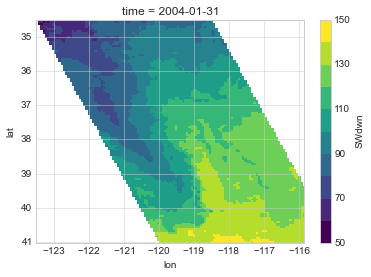

In [11]:
# Take the SWdwn field, take the monthly mean along the time dimension, select January 2004, and plot the result
wrf.SWdwn.resample('M',dim='time',how='mean').sel(time=slice('2004-02-01')).plot(origin='lower',levels=10)
# Monthly downwelling shortwave for January over California
# Plot type depends on number of dimensions: 1D array = line plot, 2D array = pcolor, 3D array = histogram

(4,
 5,
 [-121.02628560419726, 35.743415256309106, 0.0, 0.0],
 [-118.20956353113203, 39.32069173183801, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x10fcaaa10>)

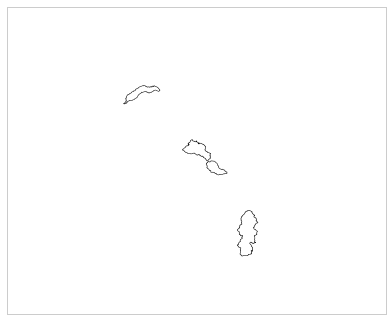

In [6]:
#####################
## Basin Shapefile ##
#####################
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

##### Basemap
lat = mtclim.latitude.values
lon = mtclim.longitude.values
bmp,bmd = kgraph.build_basemap(lon,lat,dir_bmap)
lat_labels = bmd['lat_labels']
lon_labels = bmd['lon_labels']

## Shape files
os.chdir(dir_bmap+dir_shape)
bmp.readshapefile('./SierraBasins', 'SierraBasins')

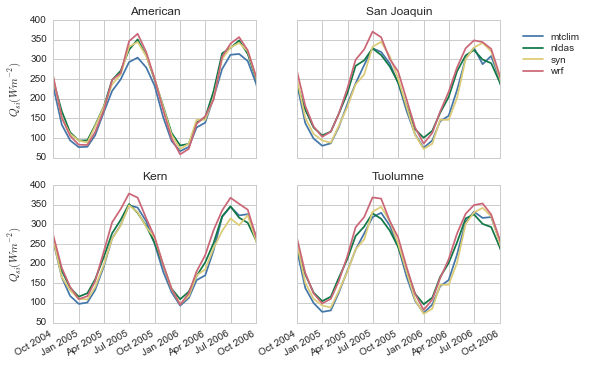

In [7]:
##########################
## Mean Qsi over basins ##
##########################

colsche = kgraph.SRON(4)

# Panda Dataframe containing basin polygons
df_map = pd.DataFrame({
    'poly': [Polygon(basin_points) for basin_points in bmp.SierraBasins],
    'name': [basins['BASIN'] for basins in bmp.SierraBasins_info]
})
   
## Points within basin
fig,axes = plt.subplots(2,2,sharex='col',sharey='row',figsize=(8,6))
axes = axes.flatten()
for k,(bname,basins) in enumerate(zip(df_map['name'],df_map['poly'])):
    ax = axes[k]
    for n,pr in enumerate(pr_names):
        
        ## Product grid lat/lon -> shapely 'point' class (find points in basin and average)
        mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
        mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
        
        # lat (index 1) /lon (index 0) of points within basin
        cont_p = contained_points(basins,mapped_points)

        ax.plot(monthly_mean[pr].time,\
                 monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points'),\
                color=colsche[n],label=pr)
    
    ## Format graphs
    if k == 1:
        ax.legend(loc='center',labelspacing=.25,markerscale=1,bbox_to_anchor=(1, .5, .5, .5))    
    ax.set_title(bname)
    ax.set_xlim(datetime(2004,10,1),datetime(2006,10,1))
    if k == 0 or k == 2:
        ax.set_ylabel('$Q_{si} (Wm^{-2})$')
    
    fig.autofmt_xdate()

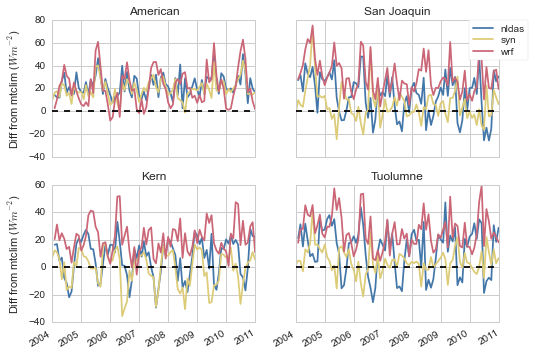

In [8]:
#####################################
## Mean Qsi difference from MTCLIM ##
#####################################

colsche = kgraph.SRON(3)

# Panda Dataframe containing basin polygons
df_map = pd.DataFrame({
    'poly': [Polygon(basin_points) for basin_points in bmp.SierraBasins],
    'name': [basins['BASIN'] for basins in bmp.SierraBasins_info]
})
   
## Points within basin
fig,axes = plt.subplots(2,2,sharex='col',sharey='row',figsize=(8,6))
axes = axes.flatten()
pr_names = ['nldas','syn','wrf']
for k,(bname,basins) in enumerate(zip(df_map['name'],df_map['poly'])):
    ax = axes[k]
    
    ## Product grid lat/lon -> shapely 'point' class (MTCLIM)
    pr = 'mtclim'
    mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
    mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
    cont_p = contained_points(basins,mapped_points)
    mc = monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points')
    
    ## Product grid lat/lon -> shapely 'point' class (Difference from MTCLIM)
    for n,pr in enumerate(pr_names):
        # Product grid lat/lon -> shapely 'point' class
        mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
        mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
        
        # lat (index 1) /lon (index 0) of points within basin
        cont_p = contained_points(basins,mapped_points)
        basin_diff = monthly_mean[pr].SWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points')-mc
        ax.plot(basin_diff.time,basin_diff,\
                color=colsche[n],label=pr)
    
    ## Format graphs
    if k == 1:
        ax.legend(loc='center',labelspacing=.25,markerscale=1,bbox_to_anchor=(.75, .6, .5, .5),frameon=True)    
    ax.set_title(bname)
    ax.set_xlim(datetime(2004,1,1),datetime(2011,1,1))
    if k == 0 or k == 2:
        ax.set_ylabel('Diff from mtclim ($Wm^{-2}$)')
    ax.plot(np.array((datetime(2004,1,1),datetime(2011,1,1))),np.array((0,0)),'k--',zorder=4)
    
fig.autofmt_xdate()
os.chdir(dir_print)
fig.savefig('BasinComparison.MTCLIMDiff.png')

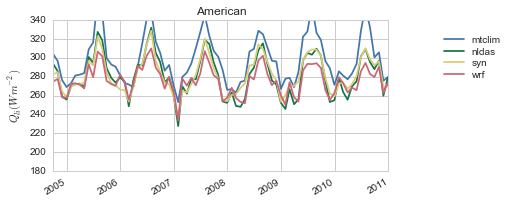

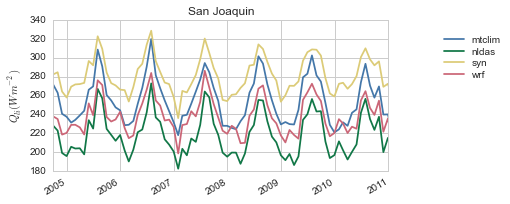

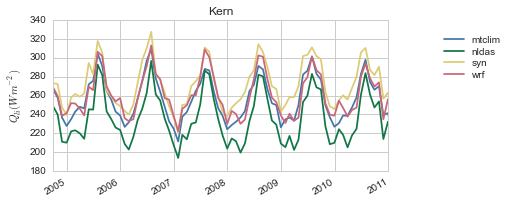

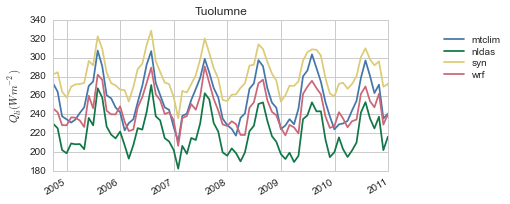

In [20]:
##########################
## Mean Qli over basins ##
##########################
colsche = kgraph.SRON(4)
pr_names = ['mtclim','nldas','syn','wrf']

# Panda Dataframe containing basin polygons
df_map = pd.DataFrame({
    'poly': [Polygon(basin_points) for basin_points in bmp.SierraBasins],
    'name': [basins['BASIN'] for basins in bmp.SierraBasins_info]
})

## Points within basin
for k,(bname,basins) in enumerate(zip(df_map['name'],df_map['poly'])):
    fig,ax = plt.subplots(1,1,figsize=(6,3))
    for n,pr in enumerate(pr_names):
        ## Product grid lat/lon -> shapely 'point' class, mean of Qli within basin
        mlon,mlat = np.meshgrid(monthly_mean[pr].longitude.values,monthly_mean[pr].latitude.values)
        mapped_points = [Point(mapped_x, mapped_y) for mapped_x, mapped_y in zip(mlon.flatten(),mlat.flatten())]
        
        # lat (index 1) /lon (index 0) of points within basin
        cont_p = contained_points(basins,mapped_points)

        ax.plot(monthly_mean[pr].time,\
                 monthly_mean[pr].LWdwn.sel_points(longitude=cont_p[0],latitude=cont_p[1]).mean('points'),\
                color=colsche[n],label=pr)
    ax.legend(loc='center',labelspacing=.25,markerscale=1,bbox_to_anchor=(1, .5, .5, .5))    
    ax.set_title(bname)
    ax.set_xlim(datetime(2004,10,1),datetime(2011,1,1))
    ax.set_ylabel('$Q_{li} (Wm^{-2})$')
    ax.set_ylim(180,340)
    
    fig.autofmt_xdate()